# Figure 9
Simulated responses under different conditions involving the tunnel, the anomaly, and metal infrastructure.

In [ ]:
from SimPEG import  maps, utils
import SimPEG.electromagnetics.time_domain as tdem
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
import empymod
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import animation, collections

try:
    from pymatsolver import Pardiso as Solver
except:
    from SimPEG import SolverLU as Solver

import sys

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('bmh')

C:\Users\RS\AppData\Local\Temp\ipykernel_23640\2016789560.py:1: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import  maps, utils


## Create a Tensor Mesh

In [2]:
def mesh_d(offset, cell, tunnel_length, depth, dir):
    delta = offset / 2
    dh = cell  # base cell width
    # dom_width = 5000.0  # domain width
    dom_width = 10000
    nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells

    # Define the base mesh
    h = [(dh, nbc)]
    mesh = TreeMesh([h, h, h], x0="CCC")
    n = tunnel_length / 2
    for i in range(int(tunnel_length)):
        x_low = -n + i + 0.1 
        # ——————————————————————————y-left——————————————————————————————————
        xp, yp, zp = np.meshgrid([x_low], [-2.5, -2.3], [-2.5, 2.5])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

        # ——————————————————————————y-right——————————————————————————————————
        xp, yp, zp = np.meshgrid([x_low], [2.4, 2.6], [-2.5, 2.5])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

        # ——————————————————————————z-upper——————————————————————————————————
        xp, yp, zp = np.meshgrid([x_low], [-2.5, 2.5], [2.4, 2.5])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    # # ——————————————————————————z-lower——————————————————————————————————
    xp, yp, zp = np.meshgrid([-n, n], [-0.7], [-2.4, -2.3])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    xp, yp, zp = np.meshgrid([-n, n], [0.7], [-2.4, -2.3])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    # # ——————————————————————————接收点加密——————————————————————————————————
    # xp, yp, zp = np.meshgrid([0.0, 0.5], [0, 0], [0, 0])
    receiver_locations = np.array([[delta+0.5, 2.5 + depth, 0]])

    # Mesh refinement near transmitters and receivers
    mesh = refine_tree_xyz(
        mesh, receiver_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    source_locations = np.array([[-delta-0.5, 2.5 + depth, 0], [-delta+0.5, 2.5 + depth, 0]])

    # # Mesh refinement near transmitters and receivers
    mesh = refine_tree_xyz(
        mesh, source_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    # # ——————————————————————————异常体区域加密——————————————————————————————————
    if dir == 1:
        x1, y1, z1 = 0, 75, 0
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    elif dir == 2:
        x1, y1, z1 = 0, 75, 75
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    elif dir == 3:
        x1, y1, z1 = 0, 0, 75
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    elif dir == 4:
        x1, y1, z1 = 0, -75, 75
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    elif dir == 5:
        x1, y1, z1 = 0, -75, 0
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    else:
        print('error')
        return 0
    # Mesh refinement near transmitters and receivers
    mesh = refine_tree_xyz(
        mesh, abnormal_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    mesh.finalize()

    return mesh, source_locations, receiver_locations, abnormal_locations[0]

In [3]:
def get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block, sigma_air, center, tunnel_length):
    thickness = 0.2

    model = np.ones(mesh.nC) * sigma_half
    mur = np.ones(mesh.nC)

    n = int(tunnel_length/2)
    ################layer####################
    layer = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
            (mesh.gridCC[:,1] >= -2.5) & (mesh.gridCC[:,1] <= 2.5) &
            (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5))

    rail1 = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
            (mesh.gridCC[:,1] >= -0.8) & (mesh.gridCC[:,1] <= -0.8 + thickness) &
            (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= -2.5 + thickness))

    rail2 = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
            (mesh.gridCC[:,1] >= 0.8 - thickness) & (mesh.gridCC[:,1] <= 0.8) &
            (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= -2.5 + thickness))
    model[layer] = sigma_air
    mur[layer] = 1  


    ################ interference ####################
    for i in range(int(tunnel_length)):
        layer_1 =   ((mesh.gridCC[:,0] >= -n+i) & (mesh.gridCC[:,0] <= -n+i+thickness) & 
                    (mesh.gridCC[:,1] >= -2.5) & (mesh.gridCC[:,1] <= 2.5) &
                    (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5))
        
        model[layer_1] = sigma_frame
        mur[layer_1] = mu_r


    layer_2 =   ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
                    (mesh.gridCC[:,1] >= -2.5 + thickness) & (mesh.gridCC[:,1] <= 2.5 - thickness) &
                    (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5 - thickness))
    model[layer_2] = sigma_air
    mur[layer_2] = 1


    model[rail1] = sigma_rail
    model[rail2] = sigma_rail
    mur[rail1] = mu_r
    mur[rail2] = mu_r
    
    ################ abnormal ####################
    block = (
        (mesh.gridCC[:,0] >= center[0]-25) & (mesh.gridCC[:,0] <= center[0]+25) & 
        (mesh.gridCC[:,1] >= center[1]-25) & (mesh.gridCC[:,1] <= center[1]+25) & 
        (mesh.gridCC[:,2] >= center[2]-25) & (mesh.gridCC[:,2] <= center[2]+25))
    model[block] = sigma_block

#     fig = plt.figure(figsize=(10,10), dpi=100)
#     plt.subplot(221)
#     plt.rcParams["font.family"] = ["Times New Roman"]
#     ax = plt.gca()
#     # mesh.plot_3d_slicer(np.log10(model), zslice = 0, fig=fig, 
#     #                     xlim=[-10, 10], ylim=[-10, 10], zlim=[-10, 10],
#     #                     )
#     dat2 = mesh.plotSlice(np.log10(model), grid= True , ax=ax, normal='x',lw=0.5)
# #     ax.grid(linewidth=2)  # 设置网格线的粗细为2
# #     ax.set_xlim([-100,100])
# #     ax.set_ylim([-100,100])
#     ax.set_xlim([-3,3])
#     ax.set_ylim([-3,3])
#     ax.set_title("Conductivity profile at X = 0")
#     ax.set_xlabel("Y / m", fontsize=12)
#     ax.set_ylabel("Z / m", fontsize=12)
#     ax.tick_params(labelsize=12)

#     plt.subplot(222)
#     ax = plt.gca()
#     dat2 = mesh.plotSlice(np.log10(model), grid= False , ax=ax,  normal='y')
#     ax.set_xlim([-50,50])
#     ax.set_ylim([-3,3])
#     ax.set_title("Conductivity profile at Y = 0")
#     ax.set_xlabel("X / m", fontsize=12)
#     ax.set_ylabel("Z / m", fontsize=12)
#     ax.tick_params(labelsize=12)

    return model, mur

In [5]:
def forward(mesh, model, mur, source_locations, receiver_locations, path):
    times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)

    # src_list = []
    rec_list = []
    # Set up the receiver list
    for i in ["x", "y", "z"]:
        rec_list.append(tdem.Rx.PointElectricField(
                orientation=i,
                times=times,
                locations=receiver_locations[0]
            ))

    # Set up the source list
    src_list = [
        tdem.Src.LineCurrent(
            receiver_list=rec_list,
            location=np.array([source_locations[0], source_locations[1]]),
        ),
    ]


    # Create `Survey`
    survey = tdem.Survey(src_list)

    # time_steps = [1e-1, (1e-2, 21), (3e-2, 23), (1e-1, 21), (3e-1, 23)]
    time_steps =  [1e-7, (1e-7,21), (3e-7,21), (1e-6,21), (3e-6,21), (1e-5, 21), (3e-5, 21),(1e-4, 21), (3e-4, 21),(1e-3, 21)]
    # Define the `Simulation`
    prob = tdem.Simulation3DElectricField(
        mesh,
        survey=survey,
        sigmaMap=maps.IdentityMap(mesh),
        solver=Solver,
        time_steps=time_steps,
        verbose = True
    )

    # Run the forward simulation
    prob.mu = mur*mu_0
    dpred = prob.dpred(model)

    np.save(path, dpred)

    return 0

### No tunnel and metal infrastructure

In [6]:
# mu_r = 1
# sigma_half = round(1 / 300, 4)
# sigma_block = [sigma_half, 1]
# sigma_tunnel = sigma_half#1e-8
# sigma_frame = sigma_half
# sigma_rail  = sigma_half

# depth = [0]
# offset = [10]
# distance = [50]

# name = ["noTunnel&noInterference", "Tunnel&noInterference", "Tunnel&Interference"]

# for i in range(len(sigma_block)):
#     path = './data_fig10/Exyz_block{}_depth{}m_offset{}_distance{}_{}.npy'.format(
#         sigma_block[i], 
#         depth[0], 
#         offset[0], 
#         distance[0],
#         name[0])
#     mesh, source_locations, receiver_locations, center = mesh_d(offset[0], depth[0], distance[0])
#     model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block[i], sigma_tunnel, center)
#     forward(mesh, model, mur, source_locations, receiver_locations, path)

### Tunnel without metal infrastructure

In [7]:
# mu_r = 1
# sigma_half = round(1 / 300, 4)
# sigma_block = [sigma_half, 1]
# sigma_tunnel = 1e-8
# sigma_frame = sigma_tunnel
# sigma_rail  = sigma_tunnel

# depth = [0]
# offset = [10]
# distance = [50]

# name = ["noTunnel&noInterference", "Tunnel&noInterference", "Tunnel&Interference"]

# for i in range(len(sigma_block)):
#     path = './data_fig10/Exyz_block{}_depth{}m_offset{}_distance{}_{}.npy'.format(
#         sigma_block[i], 
#         depth[0], 
#         offset[0], 
#         distance[0],
#         name[1])
#     mesh, source_locations, receiver_locations, center = mesh_d(offset[0], depth[0], distance[0])
#     model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block[i], sigma_tunnel, center)
#     forward(mesh, model, mur, source_locations, receiver_locations, path)

### Tunnel with metal infrastructure

In [8]:
def effective_conductivity(sigma_steel, sigma_back, S_steel, S_cell):
    #sigma_real * A_real / A_eff
    sigma_eff = sigma_steel * (S_steel / S_cell) + sigma_back * (S_cell - S_steel) / S_cell
    return sigma_eff

In [9]:
sigma_half = round(1 / 300, 4)
sigma_steel = 5e6
sigma_tunnel = 1e-8
sigma_block = [sigma_half, 1]

cell = [0.05]
tunnel_length = [100, 200]

mu_r = 100
sigma_frame = effective_conductivity(sigma_steel, sigma_tunnel, 21.5e-4, pow(4*cell[0], 2))
sigma_rail  = effective_conductivity(sigma_steel, sigma_tunnel, 50.8e-4, pow(4*cell[0], 2))

offset = [0, 5, 10, 20, 30, 50]
dir = [1, 2, 3, 4, 5]   # 异常体的方位
depth = [0]

name = ["noTunnel&noInterference", "Tunnel&noInterference", "Tunnel&Interference"]

for i in range(len(sigma_block)):
    path = "./data_fig10_new/Exyz_block{}_depth{}m_offset{}m_tunnel{}m.npy".format(
    sigma_block[i], 
    depth[0], 
    offset[2], 
    name[2], 
    tunnel_length[0])

    mesh, source_locations, receiver_locations, center = mesh_d(offset[2], cell[0], tunnel_length[0], depth[0], dir[0])
    model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block[i], sigma_tunnel, center, tunnel_length[0])
    forward(mesh, model, mur, source_locations, receiver_locations, path)

Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-07)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    

### Plot fig.9

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


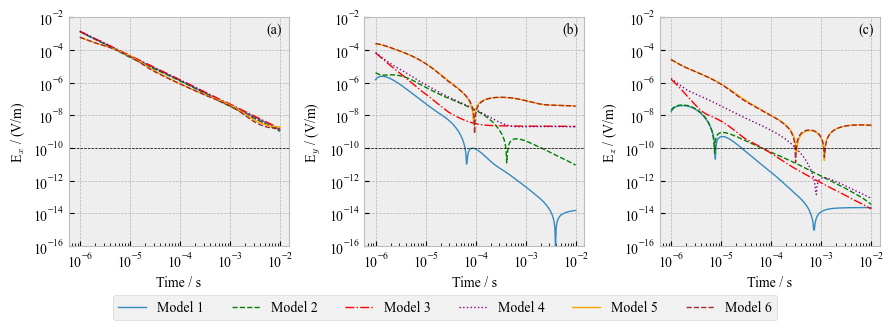

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

mu_r = 100
sigma_half = round(1 / 300, 4)
sigma_block = [sigma_half, 1]
sigma_tunnel = 1e-8
sigma_frame = 5e5
sigma_rail  = 1.25e6

depth = [0]

offset = [0, 5, 10, 20, 30, 50]
dir = [1, 2, 3, 4, 5]   # 异常体的方位
tunnel_length = [100, 200]
distance = [50]

dir = ['x', 'y', 'z']
times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)
# line = ['-', '--', '-.', ':']
colors = ['C0', 'green', 'red', 'purple', 'orange', 'brown']
linestyles = ['-', '--', '-.', ':', '-', '--', ]

name = ["noTunnel&noInterference", "Tunnel&noInterference", "Tunnel&Interference"]

Dobs = []
for j in range(len(name)):
    dobs = []
    for i in range(len(sigma_block)):
        if j < 2:
            path = './data_fig9/Exyz_block{}_depth{}m_offset{}_distance{}_{}.npy'.format(
                sigma_block[i], 
                depth[0], 
                offset[2], 
                distance[0],
                name[j])
            dobs.append(np.load(path).reshape(3, times.size))
        else:
            path = "./data_fig9_new/Exyz_block{}_depth{}m_offset{}m_tunnel{}m.npy".format(
                sigma_block[i], 
                depth[0], 
                offset[2], 
                name[2], 
                tunnel_length[0])
            dobs.append(np.load(path).reshape(3, times.size))
    Dobs.append(dobs)

fig = plt.figure(figsize=(9, 3.2), dpi=100)
plt.rcParams["font.family"] = ["Times New Roman"]

label = ["No abnormal", "Abnormal"]
label1 = ["No tunnel + No metal", "Tunnel + No metal", "Tunnel + Metal"] 
font = 10

noise_level = np.ones(times.shape[0]) * 1e-10
abnormal_label = [0, 1] 
model_label = [1, 3, 5]

k = 1
for k in range(len(dir)):
    ax = plt.subplot(1, 3, k+1)
    for i in range(len(name)):
        for j in range(len(sigma_block)):
            label2 = "Model {}".format(model_label[i] + abnormal_label[j])
        
            ax.loglog(times, np.abs(Dobs[i][j][k]), color = colors[i*len(sigma_block) + j], linestyle = linestyles[i*len(sigma_block) + j], label=label2, lw = 1)
            # ax.loglog(times, np.abs(Dobs[i][j][k]), "C{}{}".format(i*len(sigma_block) + j, linestyles[i*len(sigma_block) + j]), label=label2, lw = 1.5)

    ax.loglog(noise_level, 'k--', lw=0.5)
    
    ax.text(0.90, 0.98, f"({chr(97+k)})", transform=ax.transAxes, fontsize=font, verticalalignment='top')
    ax.set_xlabel('Time / s', fontsize=font)
    ax.set_ylabel('E$_{}$ / (V/m)'.format(dir[k]), fontsize=font)
    # ax.grid(True, c="0.9")
    ax.tick_params(axis='both', which='major', labelsize=font)
    ax.set_xlim([6e-7, 1.5e-2])
    ax.set_ylim([1e-16, 1e-2])
# 将图例放置在图片下方
handles, labels = [], []
# for ax in fig.axes:
for handle, label in zip(*ax.get_legend_handles_labels()):
    handles.append(handle)
    labels.append(label)

fig.legend(handles, labels, loc='lower center',  bbox_to_anchor=(0.5, -0.04), ncol=6, fontsize=font)


plt.tight_layout(rect=[0, 0.03, 1, 1])  # 调整布局以给图例留出空间

plt.savefig('./figure9.eps', dpi=350, bbox_inches="tight")
plt.savefig('./figure9.png', dpi=350, bbox_inches="tight")
plt.savefig('./figure9.tiff', dpi=350, bbox_inches="tight")